In [1]:
from ptycho.workflows.components import (
    parse_arguments,
    setup_configuration,
    load_data,
    run_cdi_example,
    save_outputs,
    logger,
    update_params
)

2024-10-16 01:43:20.716363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 01:43:20.716393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 01:43:20.717245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 01:43:20.721431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 01:43:21.261293: W tensorflow/compiler/tf2

1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-10-16 01:43:22.488475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 01:43:22.488717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read fr

In [2]:
params = {
    "nepochs": 50,
    "output_prefix": "tmp",
    "intensity_scale.trainable": True,
    "positions.provided": True,
    "probe.big": True,
    "probe.mask": False,
    "data_source": "generic",
    "gridsize": 1,
    "train_data_file_path": None,
    "test_data_file_path": None,
    "N": 128,
    "probe_scale": 4,
    "nphotons": 1e9,
    # "amp_activation": 'swish'
    
}

update_params(params)

DEBUG: Setting nphotons to 1000000000.0 in params


In [3]:
dpath = 'als.npy.npz'# '../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz'
dpath = 'als128.npy.npz'# '../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz'
import sys
sys.argv = [sys.argv[0], '--train_data_file_path', dpath,
           '--test_data_file_path', dpath]
args = parse_arguments()
config = setup_configuration(args, args.config)

2024-10-16 01:43:23,052 - INFO - Configuration setup complete
2024-10-16 01:43:23,053 - INFO - Final configuration: {'N': 128, 'offset': 4, 'gridsize': 1, 'outer_offset_train': None, 'outer_offset_test': None, 'batch_size': 16, 'nepochs': 50, 'n_filters_scale': 2, 'output_prefix': 'tmp', 'big_gridsize': 10, 'max_position_jitter': 10, 'sim_jitter_scale': 0.0, 'default_probe_scale': 0.7, 'mae_weight': 0.0, 'nll_weight': 1.0, 'tv_weight': 0.0, 'realspace_mae_weight': 0.0, 'realspace_weight': 0.0, 'nphotons': 1000000000.0, 'nimgs_train': 9, 'nimgs_test': 3, 'data_source': 'generic', 'probe.trainable': False, 'intensity_scale.trainable': True, 'positions.provided': True, 'object.big': True, 'probe.big': True, 'probe_scale': 4, 'set_phi': False, 'probe.mask': False, 'pad_object': True, 'model_type': 'pinn', 'label': '', 'size': 392, 'amp_activation': 'sigmoid', 'h5_path': 'wts.h5', 'npseed': 42, 'debug': True, 'gaussian_smoothing_sigma': 0.0, 'train_data_file_path': 'als128.npy.npz', 'test_d

In [4]:
from ptycho import model_manager
def main() -> None:
    """Main function to orchestrate the CDI example script execution."""
    args = parse_arguments()
    config = setup_configuration(args, args.config)
    
    try:

        #ptycho_data, ptycho_data_train, obj = load_and_prepare_data(config['train_data_file_path'])
        ptycho_data = load_data(config['train_data_file_path'], n_images = 512)
        
        test_data = None
        if config['test_data_file_path']:

            #test_data, test_ptycho_data_train, test_obj = load_and_prepare_data(config['test_data_file_path'])
            test_data = load_data(config['test_data_file_path'])

        recon_amp, recon_phase, results = run_cdi_example(ptycho_data, test_data, config)
        model_manager.save(config['output_prefix'])
        save_outputs(recon_amp, recon_phase, results, config['output_prefix'])
    except Exception as e:
        logger.error(f"An error occurred during execution: {e}")
        raise

In [5]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
import numpy as np
from ptycho.loader import RawData
import matplotlib.pyplot as plt
from ptycho.loader import RawData

from ptycho.misc import memoize_disk_and_memory

# @memoize_disk_and_memory
def generate_simulated_data(objectGuess, probeGuess, nimages, buffer, random_seed=None, return_patches=True):
    """
    Generate simulated ptychography data using random scan positions.

    Args:
        objectGuess (np.ndarray): Complex-valued 2D array representing the object.
        probeGuess (np.ndarray): Complex-valued 2D array representing the probe.
        nimages (int): Number of scan positions to generate.
        buffer (float): Border size to avoid when generating coordinates.
        random_seed (int, optional): Seed for random number generation. If None, uses system time.

    Returns:
        RawData: A RawData instance containing the simulated ptychography data.

    Raises:
        ValueError: If input parameters are invalid.
        RuntimeError: If an error occurs during simulation.
    """
    # Input validation
    if objectGuess.ndim != 2 or probeGuess.ndim != 2:
        raise ValueError("objectGuess and probeGuess must be 2D arrays")
    if not np.iscomplexobj(objectGuess) or not np.iscomplexobj(probeGuess):
        raise ValueError("objectGuess and probeGuess must be complex-valued")
    if nimages <= 0 or buffer < 0:
        raise ValueError("nimages must be positive and buffer must be non-negative")

    # Get object dimensions
    height, width = objectGuess.shape

    # Ensure buffer doesn't exceed image dimensions
    buffer = min(buffer, min(height, width) / 2 - 1)

    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random coordinates (floats)
    xcoords = np.random.uniform(buffer, width - buffer, nimages)
    ycoords = np.random.uniform(buffer, height - buffer, nimages)

    # Create scan_index
    scan_index = np.zeros(nimages, dtype=int)

    # Generate simulated data
    return RawData.from_simulation(xcoords, ycoords, probeGuess, objectGuess, scan_index, return_patches=return_patches)

    return raw_data



import numpy as np
from ptycho.loader import RawData

def load_probe_object(file_path):
    """
    Load object and probe guesses from a .npz file.

    Args:
        file_path (str): Path to the .npz file containing objectGuess and probeGuess.

    Returns:
        tuple: A tuple containing (objectGuess, probeGuess)

    Raises:
        ValueError: If required data is missing from the .npz file or if data is invalid.
        RuntimeError: If an error occurs during file loading.
    """
    try:
        with np.load(file_path) as data:
            if 'objectGuess' not in data or 'probeGuess' not in data:
                raise ValueError("The .npz file must contain 'objectGuess' and 'probeGuess'")
            
            objectGuess = data['objectGuess']
            probeGuess = data['probeGuess']

        # Validate extracted data
        if objectGuess.ndim != 2 or probeGuess.ndim != 2:
            raise ValueError("objectGuess and probeGuess must be 2D arrays")
        if not np.iscomplexobj(objectGuess) or not np.iscomplexobj(probeGuess):
            raise ValueError("objectGuess and probeGuess must be complex-valued")

        return objectGuess, probeGuess

    except Exception as e:
        raise RuntimeError(f"Error loading data from {file_path}: {str(e)}")

def simulate_from_npz(file_path, nimages, buffer=None, random_seed=None, return_patches=True):
    """
    Load object and probe guesses from a .npz file and generate simulated ptychography data.

    Args:
        file_path (str): Path to the .npz file containing objectGuess and probeGuess.
        nimages (int): Number of scan positions to generate.
        buffer (float, optional): Border size to avoid when generating coordinates. 
                                  If None, defaults to 5% of the smaller dimension of objectGuess.
        random_seed (int, optional): Seed for random number generation. If None, uses system time.
        return_patches (bool): If True, return ground truth patches along with simulated data.

    Returns:
        RawData or tuple: A RawData instance containing the simulated ptychography data,
                          or a tuple of (RawData, ground_truth_patches) if return_patches is True.

    Raises:
        ValueError: If input parameters are invalid.
        RuntimeError: If an error occurs during simulation or file loading.
    """
    # Load guesses from file
    objectGuess, probeGuess = load_probe_object(file_path)

    # Set default buffer if not provided
    if buffer is None:
        buffer = min(objectGuess.shape) * 0.35  # 35% of the smaller dimension

    # Generate simulated data
    return generate_simulated_data(objectGuess, probeGuess, nimages, buffer, random_seed, return_patches=return_patches)


# simulated_data, Yobj = simulate_from_npz(dpath, nimages=1000, buffer=10, random_seed=42)
# simulated_data_test, Yobj = simulate_from_npz(dpath, nimages=2000, buffer=10, random_seed=42)

simulated_data, Yobj = simulate_from_npz(dpath, nimages=1000, buffer=None, random_seed=42)
simulated_data_test, Yobj = simulate_from_npz(dpath, nimages=2000, buffer=None, random_seed=42)


input shape (None, 128, 128, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


2024-10-16 01:43:35,700 - WARNING - From /home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/tensorflow_probability/python/distributions/distribution.py:342: calling _Independent.__init__ (from tensorflow_probability.python.distributions.independent) with reinterpreted_batch_ndims=None is deprecated and will be removed after 2022-03-01.
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


diff3d shape: (1000, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (1000,)
objectGuess shape: (710, 710)
xcoords shape: (1000,)
ycoords shape: (1000,)
xcoords_start shape: (1000,)
ycoords_start shape: (1000,)
input shape (None, 128, 128, 1)
diff3d shape: (2000, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (2000,)
objectGuess shape: (710, 710)
xcoords shape: (2000,)
ycoords shape: (2000,)
xcoords_start shape: (2000,)
ycoords_start shape: (2000,)


In [5]:
#simulated_data, Yobj = simulate_from_npz(dpath, nimages=10000, buffer=10, random_seed=42)

In [5]:
from ptycho import probe
probe.set_probe_guess(None, simulated_data.probeGuess);

DEBUG: Setting probe to tf.Tensor(
[[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]], shape=(128, 128, 1), dtype=complex64) in params


In [6]:
from ptycho import baselines as bl

In [7]:
from importlib import reload
reload(bl)

<module 'ptycho.baselines' from '/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/baselines.py'>

In [ ]:
from ptycho.workflows.components import create_ptycho_data_container

train_data = create_ptycho_data_container(simulated_data, params);
test_data = create_ptycho_data_container(simulated_data_test, params);

In [11]:
reload(bl)

<module 'ptycho.baselines' from '/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/baselines.py'>

In [14]:
np.mean(train_data.X[:, :, :, :1])

0.17041813

In [13]:
baseline_model = bl.train((train_data.X[:, :, :, :1]), train_data.Y_I[:, :, :, :1], train_data.Y_phi[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

2024-10-16 01:45:12.175353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-16 01:45:14.153838: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f74f7bd7f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-16 01:45:14.153858: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-16 01:45:14.157624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729057514.218505  740784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 [==============================] - 14s 207ms/step - loss: 1.2272 - conv2d_12_loss: 1.0099 - conv2d_19_loss: 0.2174 - val_loss: 0.9620 - val_conv2d_12_loss: 0.7459 - val_conv2d_19_loss: 0.2161 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 1s 49ms/step - loss: 0.8442 - conv2d_12_loss: 0.6293 - conv2d_19_loss: 0.2149 - val_loss: 1.1206 - val_conv2d_12_loss: 0.9099 - val_conv2d_19_loss: 0.2107 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 1s 48ms/step - loss: 0.7448 - conv2d_12_loss: 0.5340 - conv2d_19_loss: 0.2108 - val_loss: 0.6150 - val_conv2d_12_loss: 0.4074 - val_conv2d_19_loss: 0.2076 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 1s 49ms/step - loss: 0.5945 - conv2d_12_loss: 0.3863 - conv2d_19_loss: 0.2082 - val_loss: 0.5768 - val_conv2d_12_loss: 0.3702 - val_conv2d_19_loss: 0.2066 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 1s 49ms/step - loss: 0.5329 - conv2d_12_loss: 0.3250 - conv2d_19_loss: 0.2079

In [15]:
baseline_pred_I, baseline_pred_phi = baseline_model[0].predict([test_data.X[:, :, :, 0] ])

63/63 [==============================] - 1s 22ms/step


In [16]:
from ptycho import tf_helper as hh
from ptycho import loader

In [17]:
from ptycho.params import cfg
cfg['intensity_scale'] = 1 # TODO hack

In [19]:
from ptycho.nbutils import reconstruct_image

In [20]:
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

63/63 [==============================] - 2s 13ms/step
PADDING SIZE: 108
PADDING SIZE: 108


In [21]:
obj_image_pnn = loader.reassemble_position(hh.combine_complex(baseline_pred_I, baseline_pred_phi),
                           -global_offsets[:, :, :, :] , M = 20)

PADDING SIZE: 108
PADDING SIZE: 108


In [29]:
hh.trim_reconstruction(, 236)

<tf.Tensor: shape=(2000, 0, 0, 1), dtype=complex64, numpy=array([], shape=(2000, 0, 0, 1), dtype=complex64)>

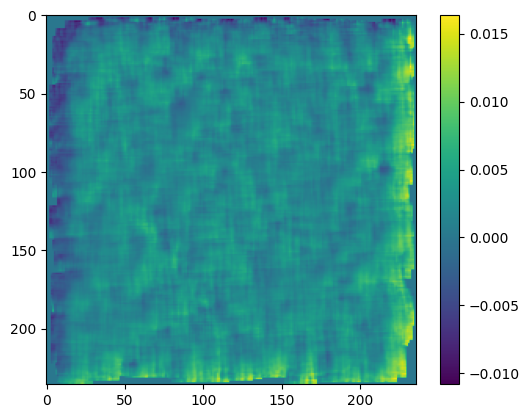

In [23]:
plt.imshow(np.angle(obj_image))
plt.colorbar()

In [46]:
import numpy as np
from ptycho.nbutils import crop_to_non_uniform_region_with_buffer, mk_epie_comparison2x2


In [79]:
from ptycho import nbutils
reload(nbutils)

<module 'ptycho.nbutils' from '/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/nbutils.py'>

In [80]:
results.keys()

dict_keys(['history', 'model_instance', 'reconstructed_obj', 'pred_amp', 'reconstructed_obj_cdi', 'stitched_obj', 'train_container', 'test_container', 'obj_tensor_full', 'global_offsets', 'recon_amp', 'recon_phase'])

In [ ]:
irange = int(np.max(global_offsets[:, 0, 1, 0]) - np.min(global_offsets[:, 0, 1, 0]))
nbutils.compare(results['obj_tensor_full'],
                results['global_offsets'],
                hh.trim_reconstruction(objectGuess[None, ..., None], irange)[0, :, :, 0],
                ptychonn_tensor=hh.combine_complex(baseline_pred_I, baseline_pred_phi))

PADDING SIZE: 109
PADDING SIZE: 109
PADDING SIZE: 109
PADDING SIZE: 109


In [47]:
objectGuess, probeGuess = load_probe_object(dpath)


212

63/63 [==============================] - 1s 9ms/step
PADDING SIZE: 108
PADDING SIZE: 108


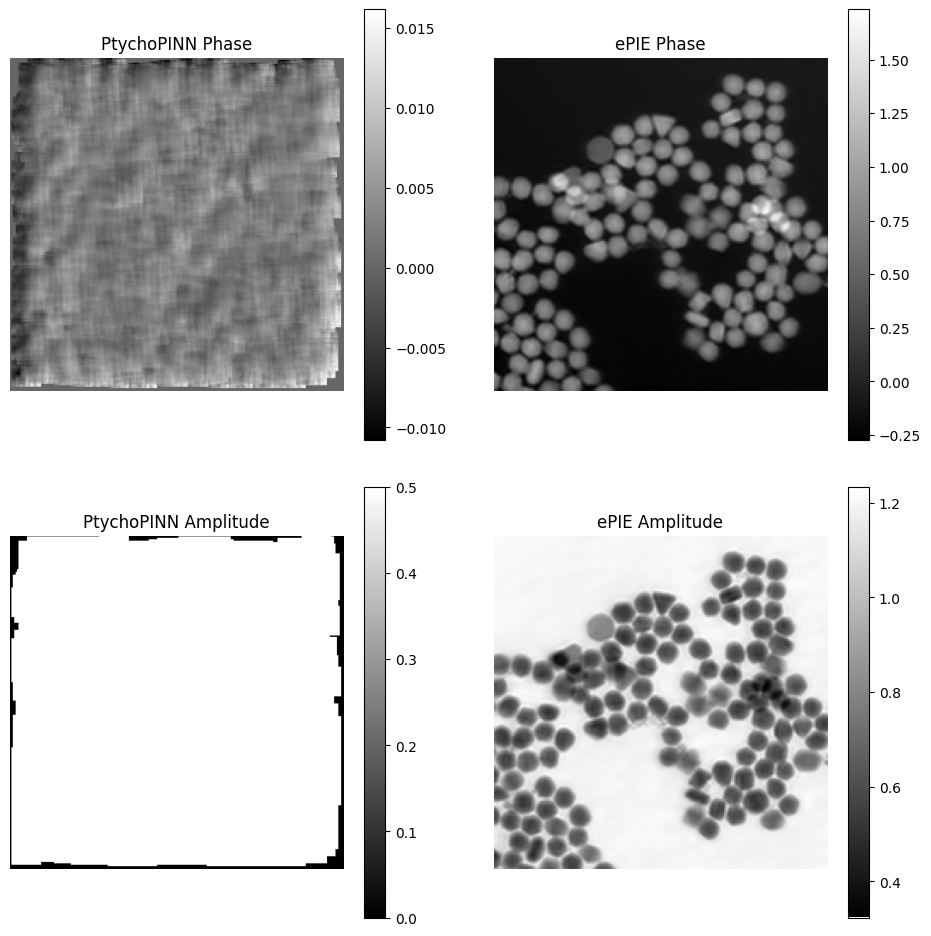

In [48]:
compare(test_data,
        hh.combine_complex(baseline_pred_I, baseline_pred_phi),
        hh.trim_reconstruction(objectGuess[None, ..., None], 236)[0, :, :, 0])

In [57]:
params

{'nepochs': 50,
 'output_prefix': 'tmp',
 'intensity_scale.trainable': True,
 'positions.provided': True,
 'probe.big': True,
 'probe.mask': False,
 'data_source': 'generic',
 'gridsize': 1,
 'train_data_file_path': None,
 'test_data_file_path': None,
 'N': 128,
 'probe_scale': 4,
 'nphotons': 1000000000.0}

In [61]:
# from ptycho import model
# reload(model)

In [59]:
recon_amp, recon_phase, results = run_cdi_example(train_data, test_data, config)

DEBUG: Setting probe to tf.Tensor(
[[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]], shape=(128, 128, 1), dtype=complex64) in params
DEBUG: Setting intensity_scale to 494.10587 in params
DEBUG: Setting probe to tf.Tensor(
[[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 

2024-10-16 02:13:03,039 - WARNING - `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/50
input shape (None, 128, 128, 1)


2024-10-16 02:13:03,757 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-10-16 02:13:03,765 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


input shape (None, 128, 128, 1)


2024-10-16 02:13:05,078 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-10-16 02:13:05,086 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
2024-10-16 02:13:05.949883: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x61e8e9a14390


60/60 [==============================] - 11s 58ms/step - loss: 468384448512.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 329.1747 - distribution_lambda_loss: 468384448512.0000 - val_loss: 4667814912.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 74.2136 - val_distribution_lambda_loss: 4667814912.0000 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 1s 19ms/step - loss: 5130750976.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 75.8170 - distribution_lambda_loss: 5130750976.0000 - val_loss: 4662332416.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 74.2028 - val_distribution_lambda_loss: 4662332416.0000 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 1s 19ms/step - loss: 5126822912.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 75.8137 - distribution_lambda_loss: 5126822912.0000 - val_loss: 4659839488.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multi

2024-10-16 02:14:15,786 - INFO - Shape of global_offsets: (2000, 1, 2, 1)


PADDING SIZE: 108
PADDING SIZE: 108


In [55]:
import tensorflow as tf

tf.random.set_seed(45)
np.random.seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
ptycho_dataset.test_data.X.shape, ptycho_dataset.train_data.X.shape

DEBUG: Setting timestamp to 10/16/2024, 02:10:23 in params


KeyError: 'diff3d is not a file in the archive'

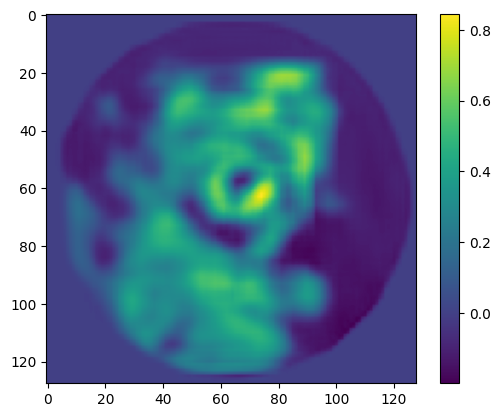

In [24]:
plt.imshow(baseline_pred_phi[300])
plt.colorbar()

In [10]:
import numpy as np
import tensorflow as tf
from ptycho.loader import RawData
from typing import Union


def save_simulated_data(simulated_data: RawData, Yobj: Union[np.ndarray, tf.Tensor], output_path: str) -> None:
    """
    Save simulated ptychography data, coordinates, and ground truth object patches to a .npz file.

    Args:
        simulated_data (RawData): The RawData object containing simulated ptychography data.
        Yobj (Union[np.ndarray, tf.Tensor]): The ground truth object patches, either as a NumPy array or TensorFlow tensor.
        output_path (str): Path where the .npz file will be saved.

    Raises:
        ValueError: If the input data is invalid or incomplete.
        IOError: If there's an error saving the file.
    """
    try:
        # Input validation
        if not isinstance(simulated_data, RawData):
            raise ValueError("simulated_data must be a RawData object")
        if not isinstance(Yobj, (np.ndarray, tf.Tensor)):
            raise ValueError("Yobj must be either a numpy array or a TensorFlow tensor")
        
        # Convert TensorFlow tensor to NumPy array if necessary
        if isinstance(Yobj, tf.Tensor):
            Yobj = Yobj.numpy()

        # Prepare data for saving
        save_dict = {
            'diffraction_patterns': simulated_data.diff3d,
            'x_coordinates': simulated_data.xcoords,
            'y_coordinates': simulated_data.ycoords,
            'ground_truth_patches': Yobj,
            'probe_guess': simulated_data.probeGuess,
            'object': simulated_data.objectGuess,
        }

        # Save the data
        np.savez_compressed(output_path, **save_dict)
        print(f"Data successfully saved to {output_path}")

    except Exception as e:
        raise IOError(f"Error saving data to {output_path}: {str(e)}")

In [11]:
save_simulated_data(simulated_data, Yobj, 'lowcounts.npz')

Data successfully saved to lowcounts.npz


In [12]:
simulated_data.diff3d.shape, Yobj.shape

((10000, 64, 64), TensorShape([10000, 64, 64, 1]))

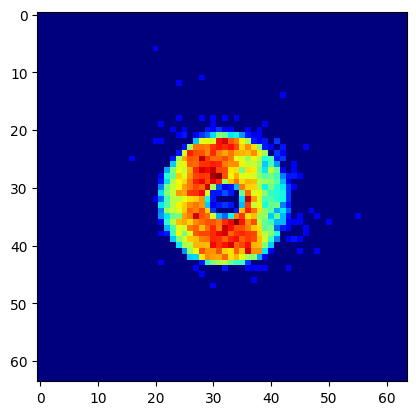

In [46]:
plt.imshow(np.abs(simulated_data.diff3d[500]), cmap = 'jet')

/tmp/ipykernel_3106494/1841352473.py:47: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(data['diffraction_patterns'][i]), cmap='viridis')


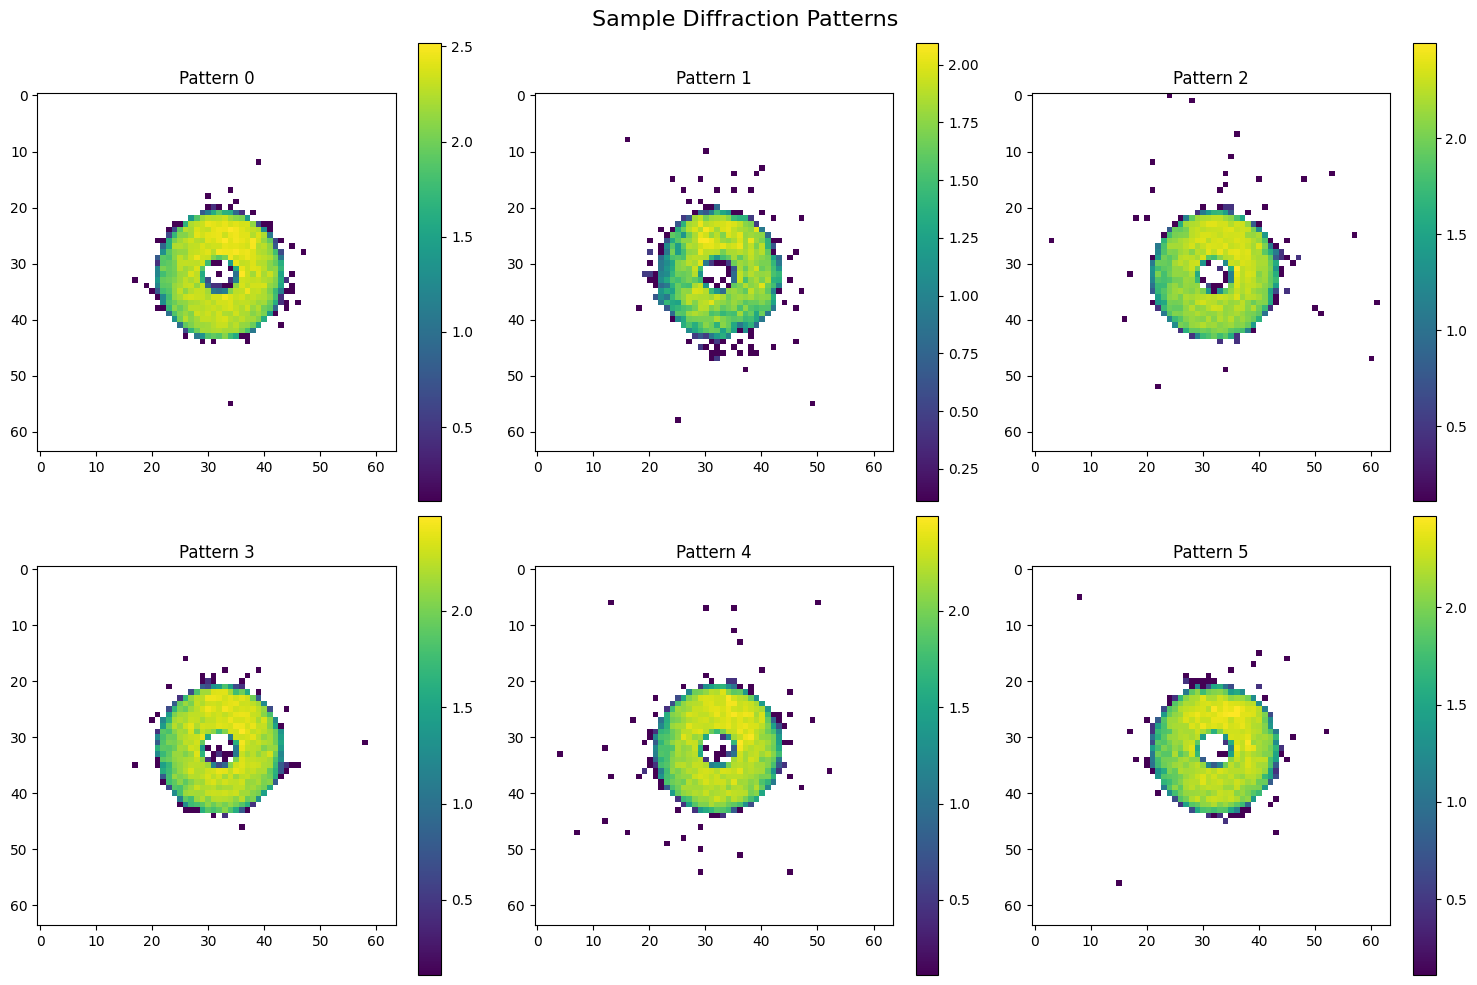

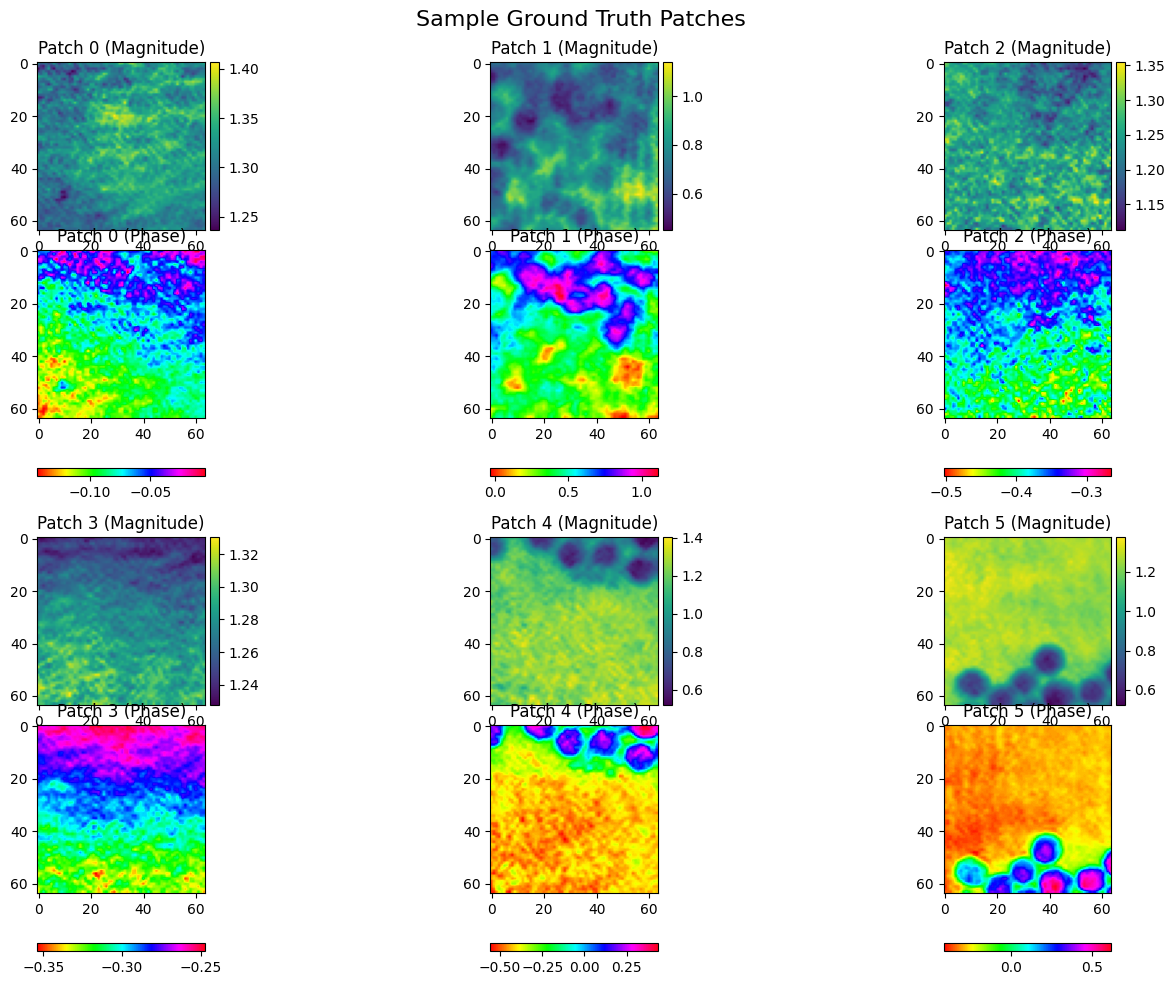

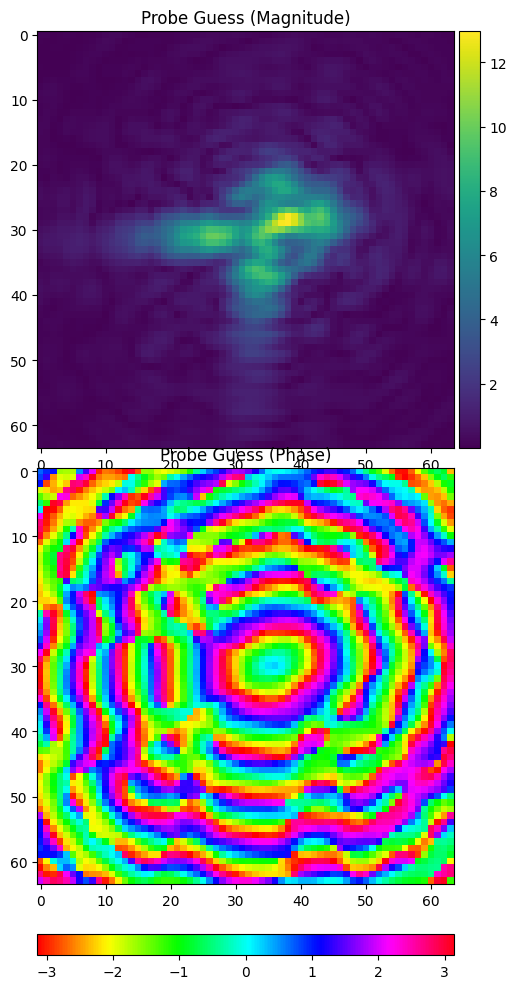

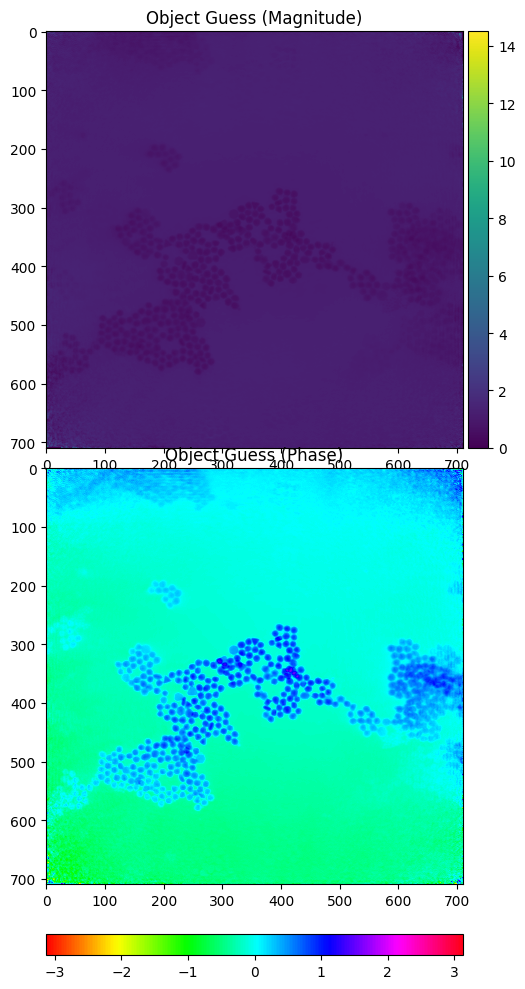

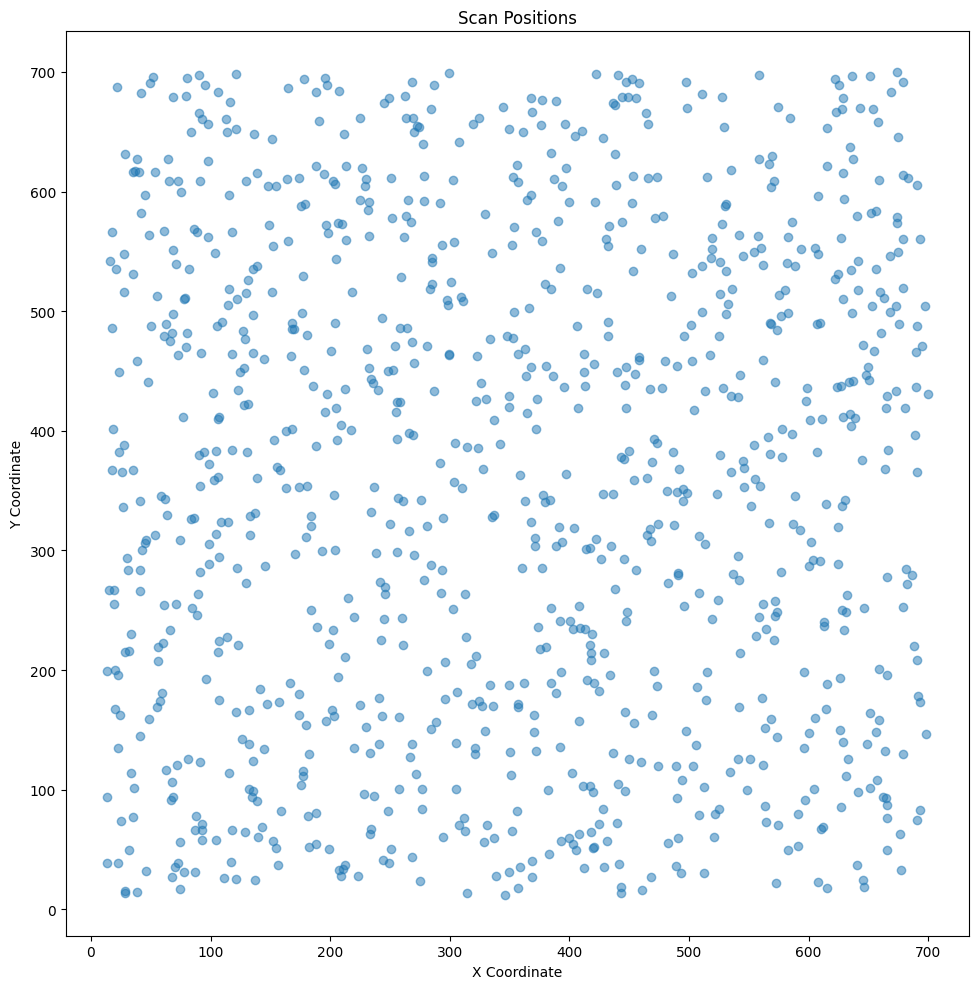

Number of diffraction patterns: 1000
Diffraction pattern shape: (64, 64)
Number of ground truth patches: 1000
Ground truth patch shape: (64, 64, 1)
Probe guess shape: (64, 64)
Object guess shape: (710, 710)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_simulated_data(file_path: str) -> dict:
    """
    Load the simulated data from a .npz file.

    Args:
        file_path (str): Path to the .npz file containing the simulated data.

    Returns:
        dict: A dictionary containing the loaded data.
    """
    try:
        with np.load(file_path) as data:
            return dict(data)
    except Exception as e:
        raise IOError(f"Error loading data from {file_path}: {str(e)}")

def plot_complex_image(ax, data, title):
    """Helper function to plot complex-valued images."""
    im = ax.imshow(np.abs(data), cmap='viridis')
    ax.set_title(f"{title} (Magnitude)")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax_phase = divider.append_axes("bottom", size="100%", pad=0.2, sharex=ax)
    im_phase = ax_phase.imshow(np.angle(data), cmap='hsv')
    ax_phase.set_title(f"{title} (Phase)")
    cax_phase = divider.append_axes("bottom", size="5%", pad=0.5)
    plt.colorbar(im_phase, cax=cax_phase, orientation="horizontal")

def visualize_simulated_data(data: dict):
    """
    Visualize the simulated ptychography data.

    Args:
        data (dict): Dictionary containing the loaded simulated data.
    """
    # Plot a sample of diffraction patterns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Sample Diffraction Patterns", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < min(6, data['diffraction_patterns'].shape[0]):
            im = ax.imshow(np.log(data['diffraction_patterns'][i]), cmap='viridis')
            ax.set_title(f"Pattern {i}")
            plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # Plot ground truth patches
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Sample Ground Truth Patches", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < min(6, data['ground_truth_patches'].shape[0]):
            plot_complex_image(ax, data['ground_truth_patches'][i], f"Patch {i}")
    plt.tight_layout()
    plt.show()

    # Plot probe guess
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_complex_image(ax, data['probe_guess'], "Probe Guess")
    plt.tight_layout()
    plt.show()

    # Plot object guess
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_complex_image(ax, data['object'], "Object Guess")
    plt.tight_layout()
    plt.show()

    # Plot scan positions
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(data['x_coordinates'], data['y_coordinates'], alpha=0.5)
    ax.set_title("Scan Positions")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load the data
    file_path = "lowcounts.npz"  # Replace with your actual file path
    simulated_data = load_simulated_data(file_path)

    # Visualize the data
    visualize_simulated_data(simulated_data)

    # Print some additional information
    print(f"Number of diffraction patterns: {simulated_data['diffraction_patterns'].shape[0]}")
    print(f"Diffraction pattern shape: {simulated_data['diffraction_patterns'].shape[1:]}")
    print(f"Number of ground truth patches: {simulated_data['ground_truth_patches'].shape[0]}")
    print(f"Ground truth patch shape: {simulated_data['ground_truth_patches'].shape[1:]}")
    print(f"Probe guess shape: {simulated_data['probe_guess'].shape}")
    print(f"Object guess shape: {simulated_data['object'].shape}")

In [25]:
Yobj[500].shape

TensorShape([64, 64, 1])

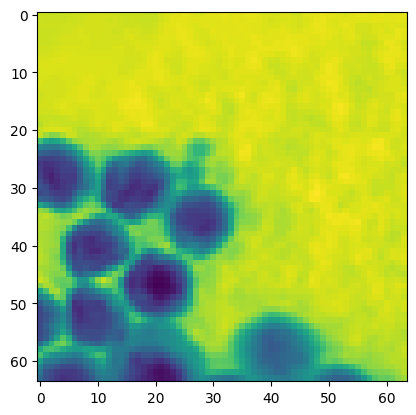

In [32]:
plt.imshow(np.abs(simulated_data.Y[500] / probeGuess))

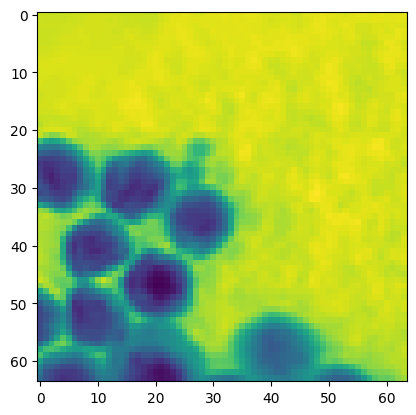

In [31]:
plt.imshow(np.abs(Yobj[500]))

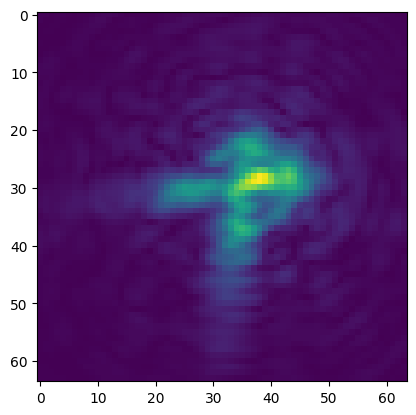

In [28]:
plt.imshow(np.abs(Yobj[500][:, :, 0] * probeGuess))

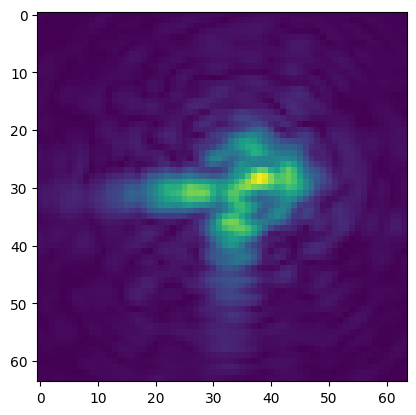

In [20]:
plt.imshow(np.abs(simulated_data.Y[150]))

In [5]:
# Do this if you want to load data from file instead of simulation

# ptycho_data_train = load_data(config['train_data_file_path'])
# if config['test_data_file_path']:
#     test_data = load_data(config['test_data_file_path'])

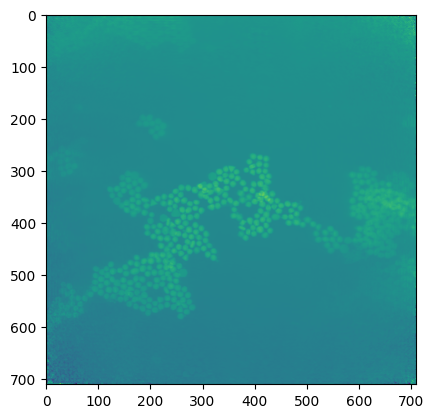

In [7]:
#objectGuess, probeGuess = load_probe_object('../ptycho/datasets/Run1084_recon3_postPC_shrunk_3.npz')
# objectGuess = objectGuess[:55, :100]
objectGuess, probeGuess = load_probe_object(dpath)

plt.imshow(np.angle(objectGuess))

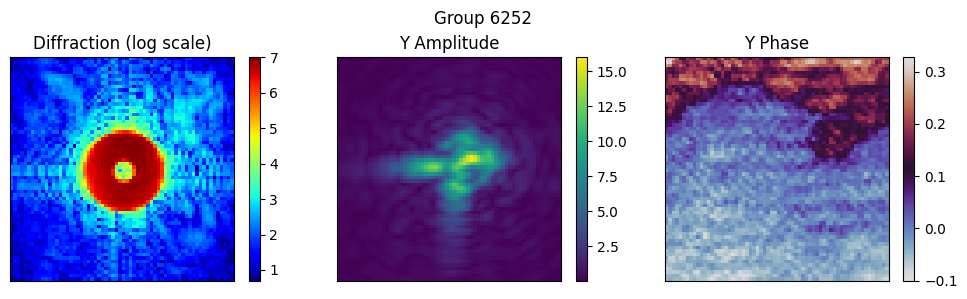

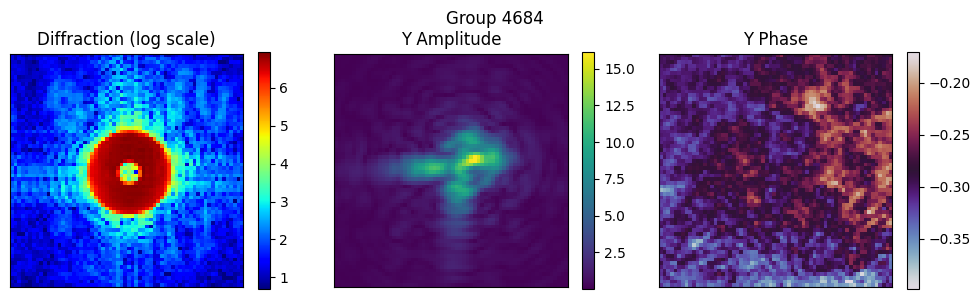

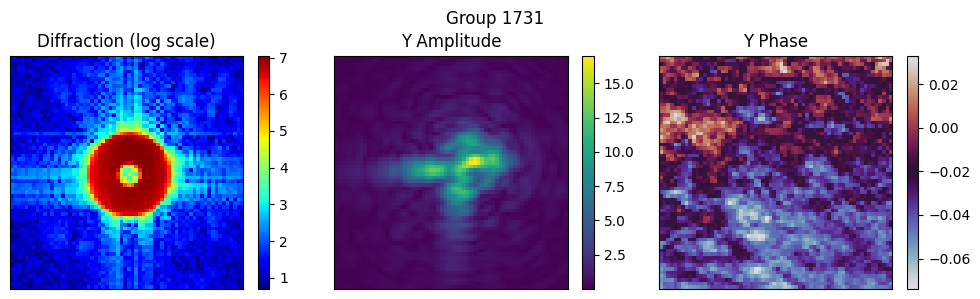

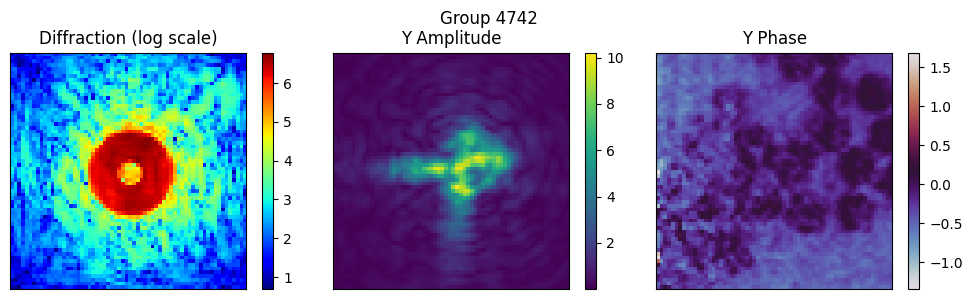

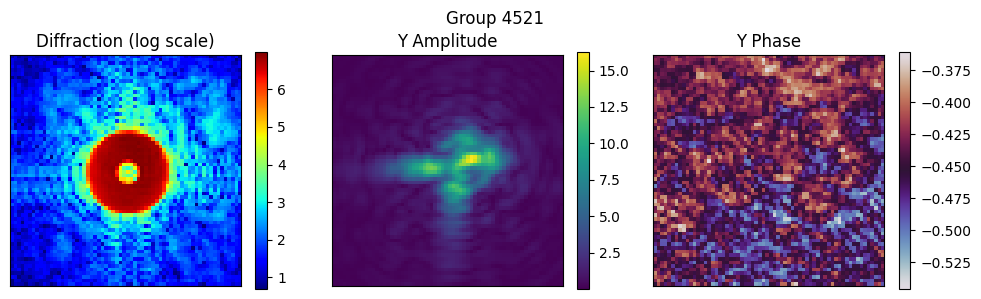

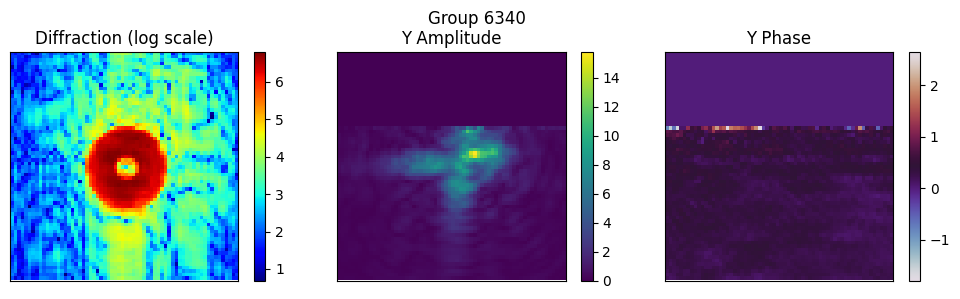

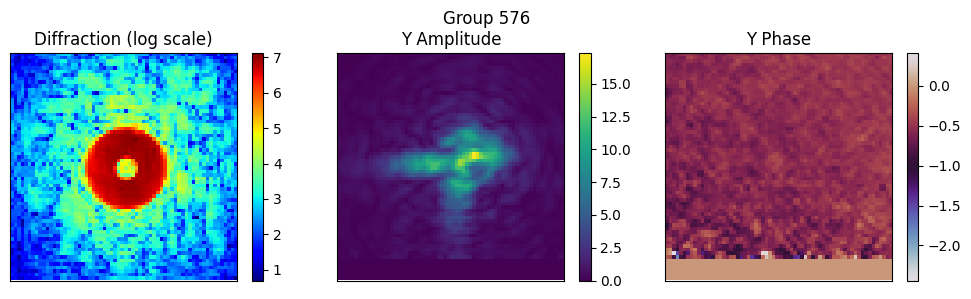

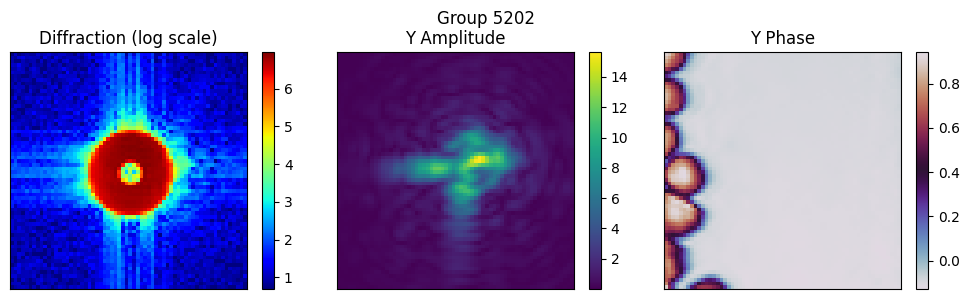

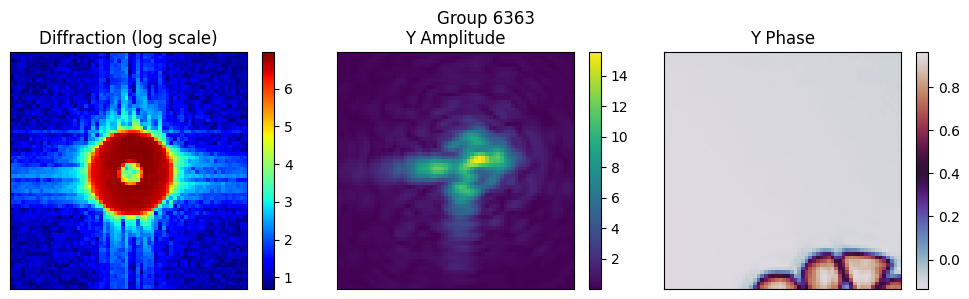

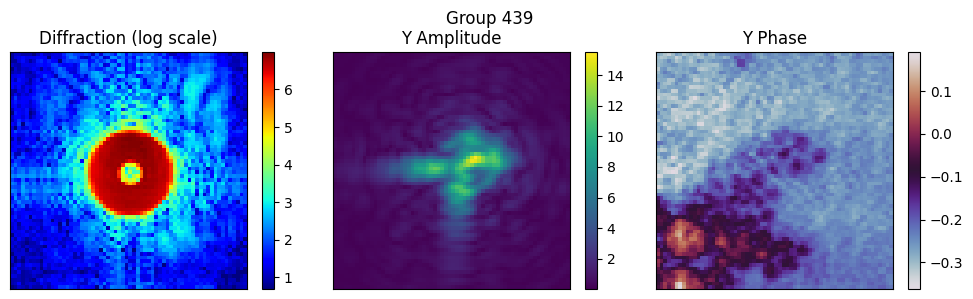

In [18]:
def plot_random_groups(tmp: RawData, K: int, figsize: tuple = (15, 5), seed: int = None):
    """
    Plot a random selection of K groups of (diffraction image, Y amplitude, Y phase) from a RawData object.

    Args:
        tmp (RawData): The RawData object containing the ptychography data.
        K (int): Number of groups to plot.
        figsize (tuple): Figure size for each group plot. Default is (15, 5).
        seed (int): Random seed for reproducibility. Default is None.

    Raises:
        ValueError: If K is greater than the number of available diffraction patterns.
    """
    if K > tmp.diff3d.shape[0]:
        raise ValueError(f"K ({K}) cannot be greater than the number of diffraction patterns ({tmp.diff3d.shape[0]})")

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Randomly select K indices
    indices = np.random.choice(tmp.diff3d.shape[0], K, replace=False)

    for idx in indices:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f"Group {idx}")

        # Plot diffraction image (log scale for better visibility)
        diff_img = axes[0].imshow(np.log1p(1 + 100 * tmp.diff3d[idx]), cmap='jet')
        axes[0].set_title("Diffraction (log scale)")
        plt.colorbar(diff_img, ax=axes[0])

        # Plot Y amplitude
        amp_img = axes[1].imshow(np.abs(tmp.Y[idx]), cmap='viridis')
        axes[1].set_title("Y Amplitude")
        plt.colorbar(amp_img, ax=axes[1])

        # Plot Y phase
        phase_img = axes[2].imshow(np.angle(tmp.Y[idx]), cmap='twilight')
        axes[2].set_title("Y Phase")
        plt.colorbar(phase_img, ax=axes[2])

        # Remove axis ticks for cleaner look
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

plot_random_groups(simulated_data, K=10, seed=42, figsize = (10, 3))

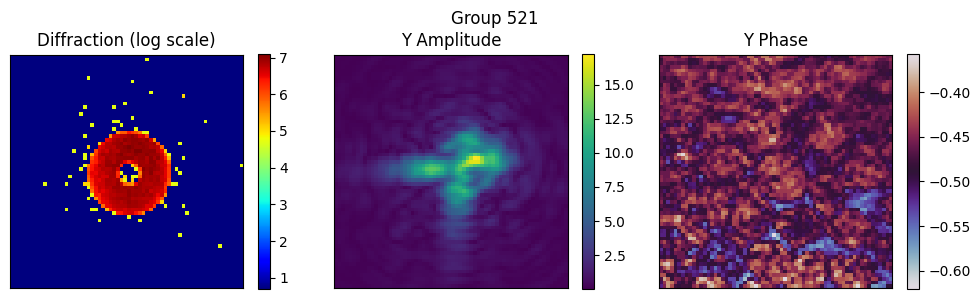

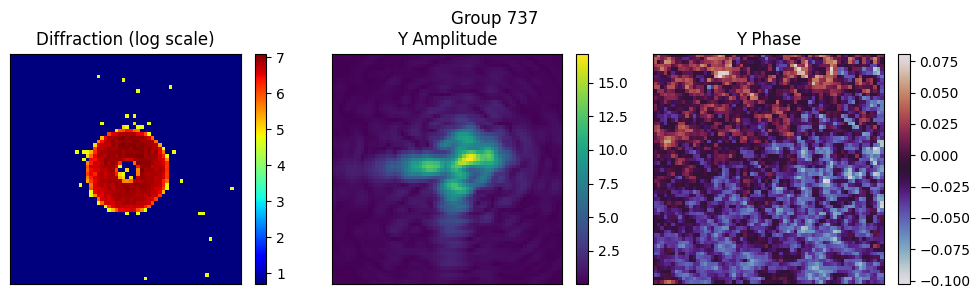

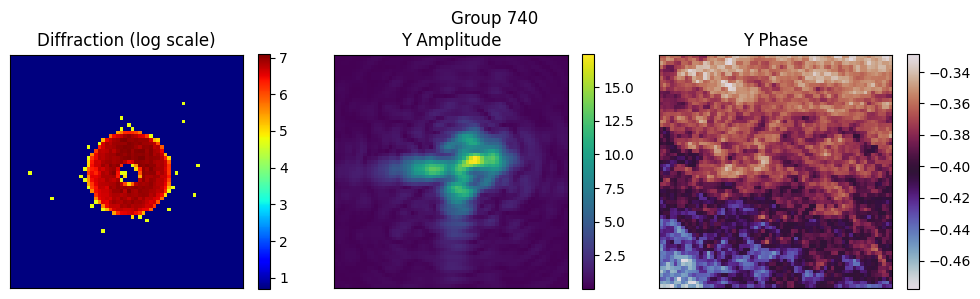

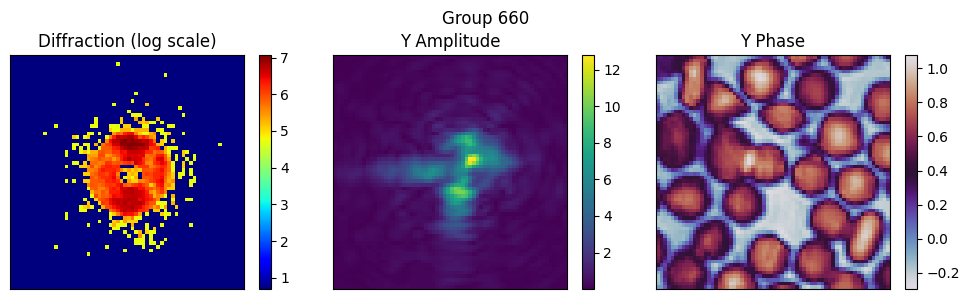

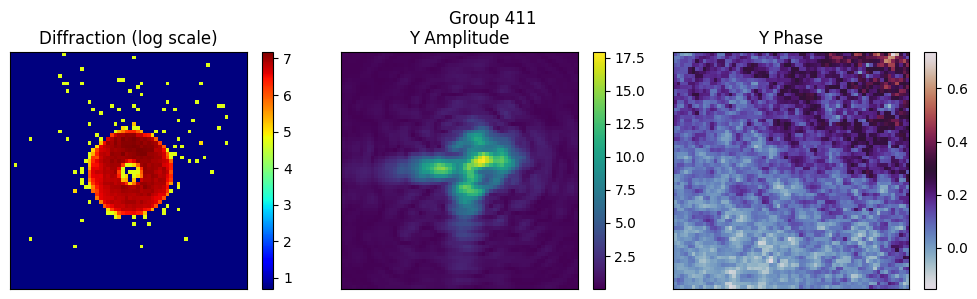

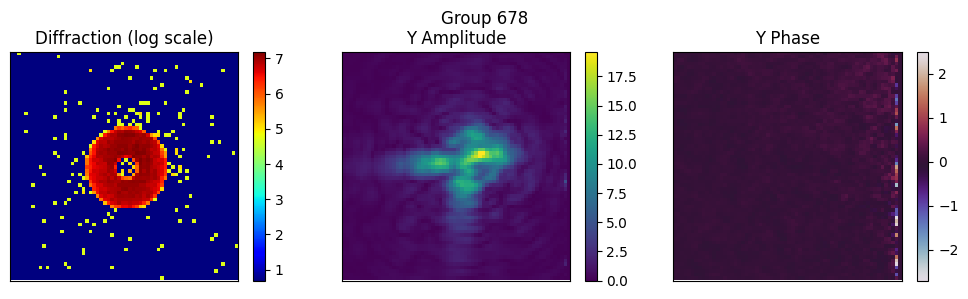

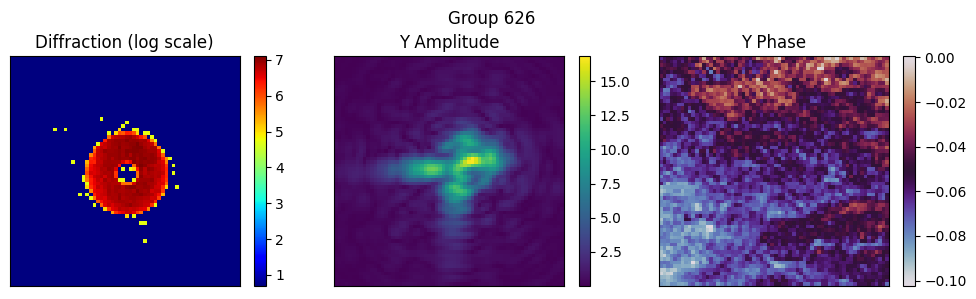

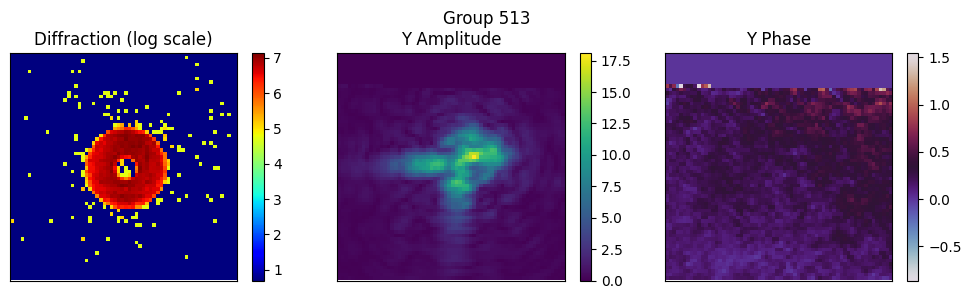

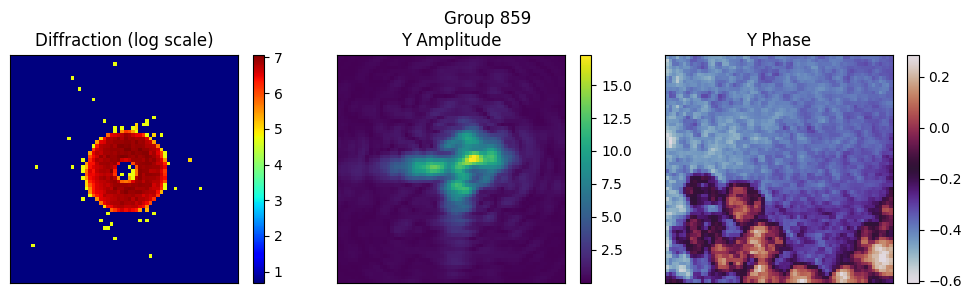

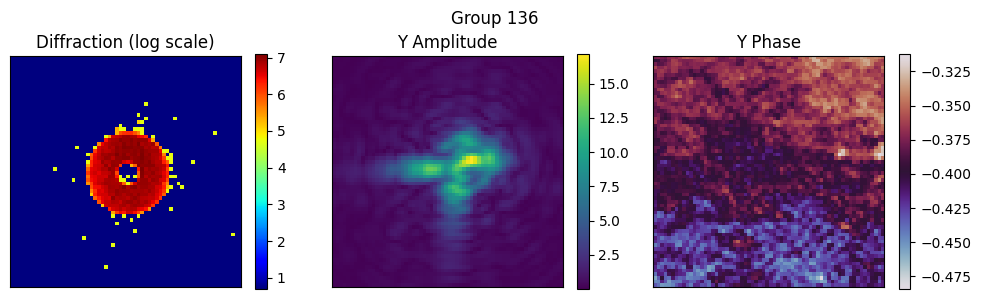

In [8]:

plot_random_groups(simulated_data, K=10, seed=42, figsize = (10, 3))

In [17]:
simulated_data.Y.shape

(1000, 64, 64)

In [62]:
# recon_amp, recon_phase, results = run_cdi_example(simulated_data, simulated_data_test, config)
recon_amp, recon_phase, results = run_cdi_example(simulated_data, simulated_data, 
    {
    "nepochs": 50,
    "output_prefix": "tmp",
    "intensity_scale.trainable": False,
    "positions.provided": True,
    "probe.big": True,
    "probe.mask": False,
    "data_source": "generic",
    "gridsize": 1,
    "train_data_file_path": None,
    "test_data_file_path": None,
    "N": 128,
    "probe_scale": 4,
    "nphotons": 1e9,
    'mae_weight': 1,
    'nll_weight': 0
    # "amp_activation": 'swish' 
}
)

DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1000, 128, 128, 1)
loader: using provided ground truth patches
INFO: None
<PtychoDataContainer X=(1000, 128, 128, 1) Y_I=(1000, 128, 128, 1) Y_phi=(1000, 128, 128, 1) norm_Y_I=() coords_nominal=(1000, 1, 2, 1) coords_true=(1000, 1, 2, 1) nn_indices=(1000, 1) mean=499.500 global_offsets=(1000, 1, 2, 1) mean=354.710 local_offsets=(1000, 1, 2, 1) mean=0.000 probe=(128, 128) mean_amplitude=1.000>
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1000, 128, 128, 1)
loader: using provided ground truth patches
INFO: None
<PtychoDataContainer X=(1000, 128, 128, 1) Y_I=(1000, 128, 128, 1) Y_phi=(1000, 128, 128, 1) norm_Y_I=() coords_nominal=(1000, 1, 2, 1) coords_true=(1000, 1, 2, 1) nn_indices=(1000, 1) mean=499.500 global_offsets=(1000, 1, 2, 1) mean=354.710 local_offsets=(1000, 1, 2, 1) mean=0.000 probe=(128, 128) mean_amplitude=1.000>
DEBUG: Setting probe to tf.Tensor(
[[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  

2024-10-16 02:16:36,236 - WARNING - `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/50
input shape (None, 128, 128, 1)


2024-10-16 02:16:36,777 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-10-16 02:16:36,785 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


input shape (None, 128, 128, 1)


2024-10-16 02:16:38,392 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2024-10-16 02:16:38,400 - WARNING - You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


60/60 [==============================] - 6s 27ms/step - loss: 575224896.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 36.7855 - distribution_lambda_loss: 575224896.0000 - val_loss: 179175888.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 28.5466 - val_distribution_lambda_loss: 179175888.0000 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 1s 19ms/step - loss: 153139408.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 26.0334 - distribution_lambda_loss: 153139408.0000 - val_loss: 178817184.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 27.9288 - val_distribution_lambda_loss: 178817184.0000 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 1s 19ms/step - loss: 134896384.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 24.0498 - distribution_lambda_loss: 134896384.0000 - val_loss: 133481688.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 24.46

2024-10-16 02:17:42,721 - INFO - Shape of global_offsets: (1000, 1, 2, 1)


PADDING SIZE: 109
PADDING SIZE: 109


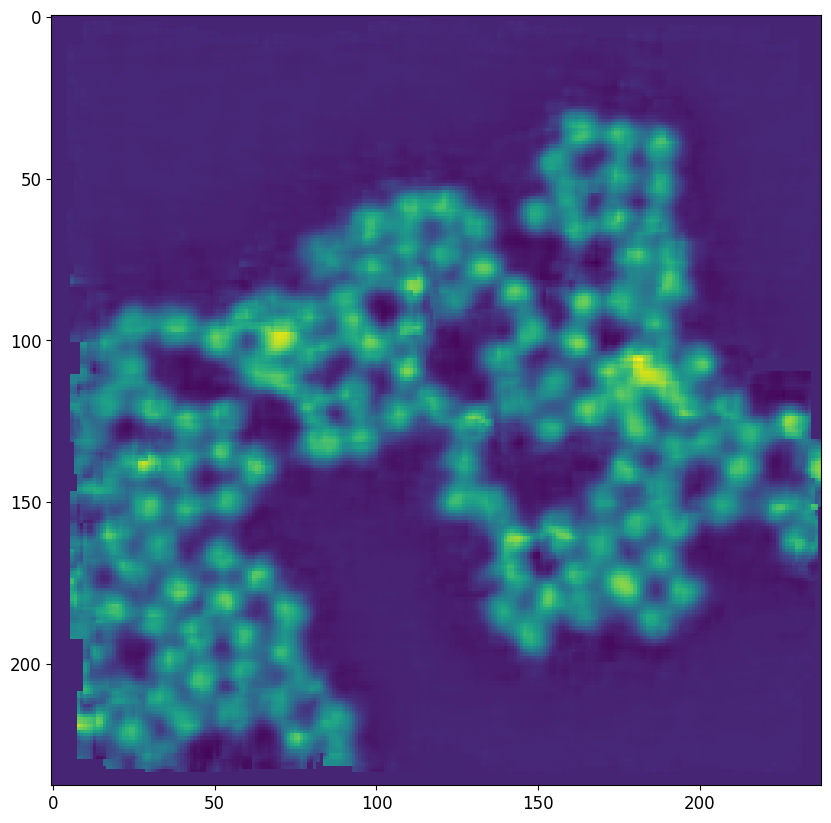

In [74]:
plt.imshow(recon_phase)

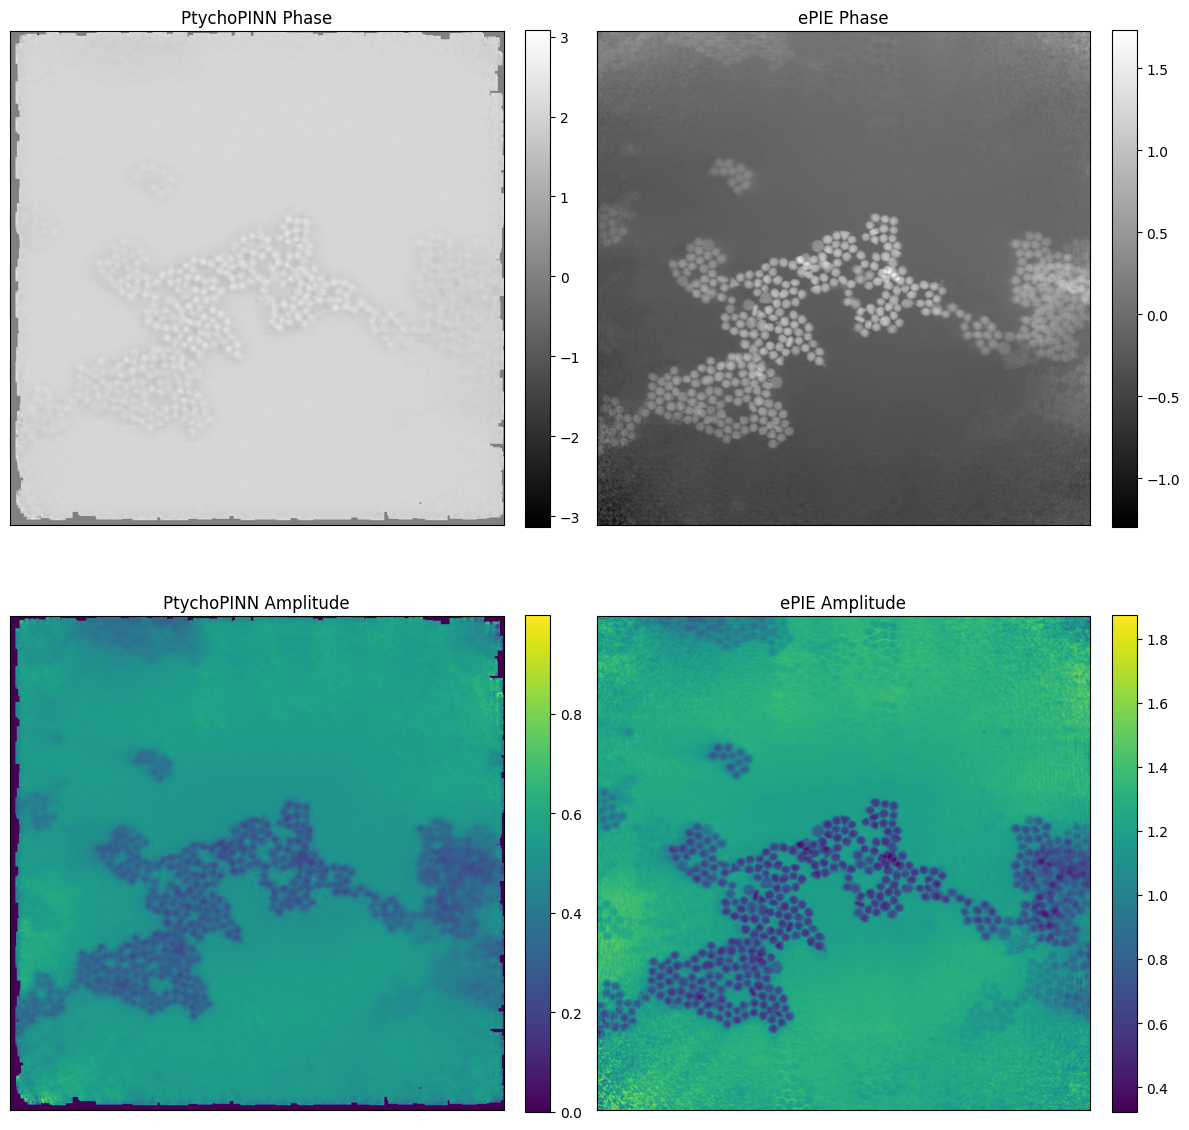

In [10]:
def save_comparison_image(reconstructed_amplitude, reconstructed_phase, epie_amplitude, epie_phase, output_path=None):
    """
    Create and display the comparison figure with reconstructed and ePIE results.
    If output_path is provided, save the figure to that path.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # PtychoPINN phase
    im_pinn_phase = axs[0, 0].imshow(reconstructed_phase, cmap='gray')
    axs[0, 0].set_title('PtychoPINN Phase')
    fig.colorbar(im_pinn_phase, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    # ePIE phase
    im_epie_phase = axs[0, 1].imshow(epie_phase, cmap='gray')
    axs[0, 1].set_title('ePIE Phase')
    fig.colorbar(im_epie_phase, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # PtychoPINN amplitude
    im_pinn_amp = axs[1, 0].imshow(reconstructed_amplitude, cmap='viridis')
    axs[1, 0].set_title('PtychoPINN Amplitude')
    fig.colorbar(im_pinn_amp, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    # ePIE amplitude
    im_epie_amp = axs[1, 1].imshow(epie_amplitude, cmap='viridis')
    axs[1, 1].set_title('ePIE Amplitude')
    fig.colorbar(im_epie_amp, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    # Remove axis ticks
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

from ptycho.nbutils import reconstruct_image, crop_to_non_uniform_region_with_buffer, mk_epie_comparison2x2, probeshow
import numpy as np
import matplotlib.pyplot as plt

epie_amplitude = crop_to_non_uniform_region_with_buffer(np.abs(objectGuess), buffer=-20)
epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(objectGuess), buffer=-20)

# Create and display the comparison image
save_comparison_image(recon_amp, recon_phase, epie_amplitude, epie_phase)

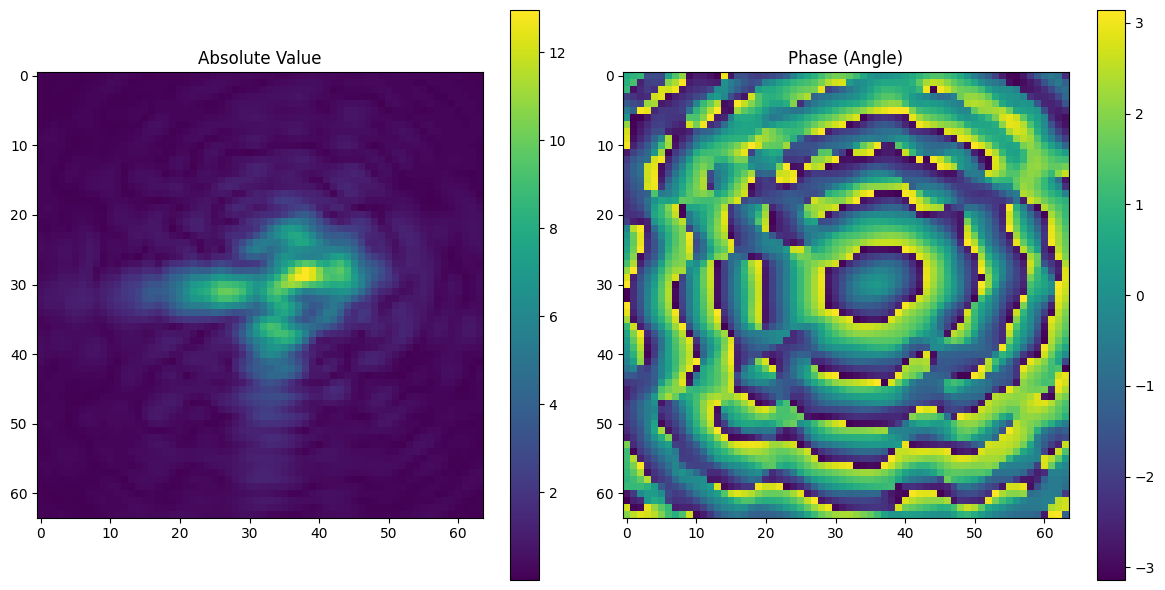

In [15]:
test_data = simulated_data_test#ptycho_dataset.test_data
# train_data = ptycho_dataset.train_data

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the absolute value in the first subplot
im1 = axes[0].imshow(np.abs(test_data.probeGuess))
axes[0].set_title('Absolute Value')
fig.colorbar(im1, ax=axes[0])

# Plot the phase (angle) in the second subplot
im2 = axes[1].imshow(np.angle(test_data.probeGuess))
axes[1].set_title('Phase (Angle)')
fig.colorbar(im2, ax=axes[1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
# loaded_mod = ModelManager.load_model('tmp/08-13-2024-16.00.27_//wts.h5')

DEBUG: Setting intensity_scale to 1474.2617 in params
input shape (1, 64, 64, 1)


Reconstruction for a single solution region:

In [5]:
# i = 200
# from ptycho import evaluation
# evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
#                      np.absolute(p.get('probe')[:, :, 0, 0]), 0,
#                     crop = False);